In [10]:
import torch
from torch import nn
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, train_test_split
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
import numpy as np
import pandas as pd
import shap  # 确保你已经安装了shap
from sklearn.preprocessing import StandardScaler
from shap.explainers import DeepExplainer
import matplotlib.pyplot as plt
import matplotlib

In [11]:
# 定义BPNN反向传播神经网络
class BPNN(BaseEstimator, RegressorMixin): # 定义BPNN的类函数，使其继承BaseEstimator, RegressorMixin两个基类，兼容sklearn的参数检验方法
    def __init__(self, num_features, hidden_layer_sizes=(50,), lr=0.01): #定义BPNN网络输入参数
        """
        初始化BP神经网络
        :param num_features: 输入特征的数量
        :param hidden_layer_sizes: 隐藏层的大小，是一个元组
        :param lr: 学习率
        """
        self.num_features = num_features # 输入特征的数量
        self.hidden_layer_sizes = hidden_layer_sizes # 隐藏层的结构
        self.lr = lr # 学习率
        self.model = None #神经网络模型将在这里定义
        self.criterion = nn.MSELoss()# 损失函数，这里使用均方误差损失
        self.optimizer = None # 优化器

    def fit(self, X, y, epochs=200):
        """
        训练模型
        :param X: 输入特征，numpy数组
        :param y: 目标值，numpy数组
        :param epochs: 训练的轮数
        """
        X_tensor = torch.FloatTensor(X) #将训练数据转化为张量
        y_tensor = torch.FloatTensor(y).view(-1, 1) #将训练数据转化为张量
        dataset = TensorDataset(X_tensor, y_tensor) # 加载数据以供训练用
        loader = DataLoader(dataset, batch_size=32, shuffle=True)# 通过dataloader创建一个可迭代的对象，将数据划分为32个批次，并在每个epoch中打乱数据
 
        # 定义模型
        layers = [nn.Linear(self.num_features, self.hidden_layer_sizes[0]), nn.ReLU()] 
        for i in range(1, len(self.hidden_layer_sizes)):
            layers.append(nn.Linear(self.hidden_layer_sizes[i-1], self.hidden_layer_sizes[i]))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(self.hidden_layer_sizes[-1], 1))
        self.model = nn.Sequential(*layers) # 创建一个由线性层和relu激活层组成的神经网络
        
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr) #Adam 优化器来调整网络参数，并使用初始化时定义的学习率 self.lr。
        
        # 训练模型
        for epoch in range(epochs): # 循环训练
            for data, target in loader:
                self.optimizer.zero_grad()# 每次训练之前清零累积的梯度。
                output = self.model(data) # 前向传播
                loss = self.criterion(output, target) # 初始化方法中定义的损失函数（MSE损失函数）来计算模型输出与目标值之间的损失
                loss.backward() # 执行反向传播，计算损失函数关于模型参数的梯度。
                self.optimizer.step() # 计算得到的梯度更新模型的权重

    def predict(self, X):
        """
        使用训练好的模型进行预测
        :param X: 输入特征，numpy数组
        """
        self.model.eval()# 调用平估的机器学习模型
        with torch.no_grad(): #预测不计算梯度
            X_tensor = torch.FloatTensor(X) #将数据转化为张量
            predictions = self.model(X_tensor) #预测结果
        return predictions.numpy() #将张量转化为mumpy数组

    def score(self, X, y):
        """
        返回模型的负MSE分数
        :param X: 输入特征，numpy数组
        :param y: 目标值，numpy数组
        """
        predictions = self.predict(X)
        return -mean_squared_error(y, predictions)

#导入数据
data = pd.read_excel(r"F:\OneDrive - csu.edu.cn\1-科技论文\3-机器学习预测算法\空气补气速度.xlsx")
# 分离特征值和结果值
data_x = np.array(data.iloc[:,0:5])
data_y =np.array(data.iloc[:,5:6]) 
X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, test_size=0.3, random_state=42)



In [13]:
X_train_origin_data = pd.DataFrame(X_train)
X_test_origin_data = pd.DataFrame(X_test)
y_train_origin_data = pd.DataFrame(y_train)
y_test_origin_data = pd.DataFrame(y_test)
train_origin_data = pd.concat([X_train_origin_data,y_train_origin_data],axis=1,ignore_index=True)
test_origin_data = pd.concat([X_test_origin_data,y_test_origin_data],axis=1,ignore_index=True)
train_origin_data = train_origin_data.to_csv(r'F:\OneDrive - csu.edu.cn\1-科技论文\3-机器学习预测算法\3-不同机器学习模型下预测效果的判定\BP-ANN\train_data.csv')
test_origin_data = test_origin_data.to_csv(r'F:\OneDrive - csu.edu.cn\1-科技论文\3-机器学习预测算法\3-不同机器学习模型下预测效果的判定\BP-ANN\test_data.csv')

In [ ]:
# 特征缩放
scaler = StandardScaler() #创建一个scaler的示例函数
X_train = scaler.fit_transform(X_train) #将训练特征转化为零均值、单位方差
X_test = scaler.transform(X_test)#将测试特征转化为零均值、单位方差
# 初始化模型
model = BPNN(num_features=X_train.shape[1])

In [6]:
# 初始化模型
model = BPNN(num_features=X_train.shape[1])

# 使用GridSearchCV进行超参数搜索
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50)],
    'lr': [0.01, 0.001, 0.0001],
       # 训练周期数
}
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

print("最佳参数：", grid_search.best_params_)
print("最佳模型分数：", -grid_search.best_score_)

最佳参数： {'hidden_layer_sizes': (100,), 'lr': 0.01}
最佳模型分数： 0.007909468844301657


In [29]:
# 将numpy数组转换为torch张量
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train).view(-1, 1)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test).view(-1, 1)

# 使用最佳参数训练模型
model = grid_search.best_estimator_

# 预测和评估
y_test_pred = model.predict(X_test_tensor.numpy())
mse = mean_squared_error(y_test_tensor.numpy(), y_test_pred)
print("均方根误差（MSE）: ", mse)
r2_test = r2_score(y_test_tensor.numpy(), y_test_pred)
print("测试集R平方值: ", r2_test)
y_train_pred = model.predict(X_train_tensor.numpy())
r2_train = r2_score(y_train_tensor.numpy(), y_train_pred)
print("训练集R平方值: ", r2_train)

# 对测试集进行MAE计算
mae_test = mean_absolute_error(y_test, y_test_pred)
print("测试集MAE: ", mae_test)
# 对训练集进行MAE计算
mae_train = mean_absolute_error(y_train, y_train_pred)
print("训练集MAE: ", mae_train)

# 使用最佳参数的模型进行预测
y_test_pred = grid_search.predict(X_test)
y_train_pred = grid_search.predict(X_train)

均方根误差（MSE）:  0.0074380264
测试集R平方值:  0.9898540335865182
训练集R平方值:  0.9961085885359116
测试集MAE:  0.06564468136587602
训练集MAE:  0.040836577453582566


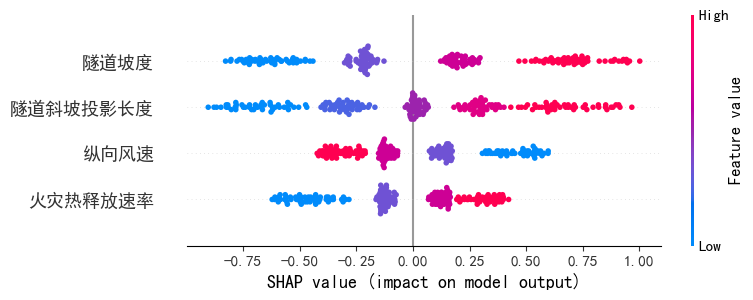

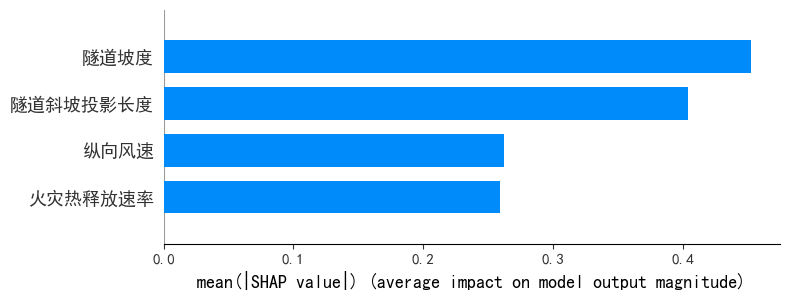

In [55]:
# 通过SHAP图标来解释BPNN模型
shap.initjs()
matplotlib.rcParams['font.sans-serif'] = ['SimHei']  # 或者你安装的任何支持中文的字体
matplotlib.rcParams['font.family']='sans-serif'
# 解决负号'-'显示为方块的问题
matplotlib.rcParams['axes.unicode_minus'] = False
feature_names = ['隧道斜坡投影长度', '隧道坡度', '火灾热释放速率',  '纵向风速']
explainer = shap.Explainer(model.predict,X_train,feature_names=feature_names)
shap_values = explainer(X_train)
# 生成第一个图表并保存
shap.summary_plot(shap_values, X_train)
# 生成第二个图表并保存
shap.summary_plot(shap_values, X_train, plot_type="bar")

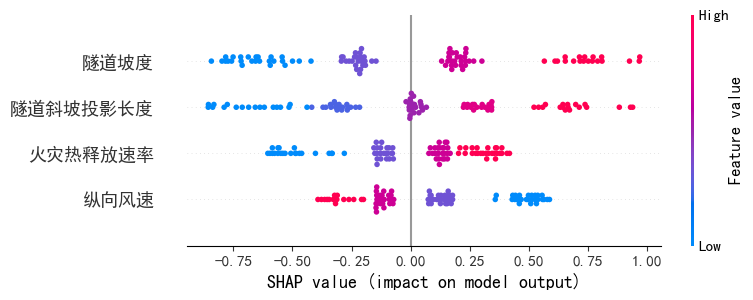

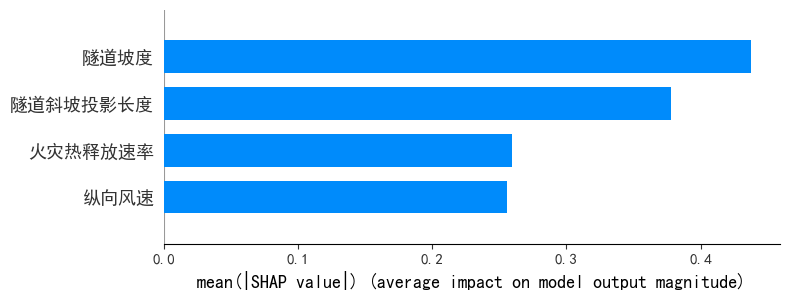

In [56]:
shap.initjs()
explainer = shap.Explainer(model.predict,X_test)
matplotlib.rcParams['font.sans-serif'] = ['SimHei']  # 或者你安装的任何支持中文的字体
matplotlib.rcParams['font.family']='sans-serif'
# 解决负号'-'显示为方块的问题
matplotlib.rcParams['axes.unicode_minus'] = False
feature_names = ['隧道斜坡投影长度', '隧道坡度', '火灾热释放速率',  '纵向风速']
explainer = shap.Explainer(model.predict,X_train,feature_names=feature_names)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")

In [12]:
# train数据的保存
y_train_data = pd.DataFrame(y_train)
y_train_data = y_train_data.reset_index()
y_train_pred_data = pd.DataFrame(y_train_pred)
y_train_pred_data = y_train_pred_data.reset_index()
train_data = pd.concat([y_train_data,y_train_pred_data],axis=1,ignore_index=True)
train_data_base = train_data[[1,3]].to_csv(r'F:\OneDrive - csu.edu.cn\1-科技论文\3-机器学习预测算法\3-不同机器学习模型下预测效果的判定\BP-ANN\BP-ANN_train.csv')

In [13]:
# train数据的保存
y_test_data = pd.DataFrame(y_test)
y_test_data = y_test_data.reset_index()
y_test_pred_data = pd.DataFrame(y_test_pred)
y_test_pred_data = y_test_pred_data.reset_index()
test_data = pd.concat([y_test_data,y_test_pred_data],axis=1,ignore_index=True)
test_data_base = test_data[[1,3]].to_csv(r'F:\OneDrive - csu.edu.cn\1-科技论文\3-机器学习预测算法\3-不同机器学习模型下预测效果的判定\BP-ANN\BP-ANN_test.csv')

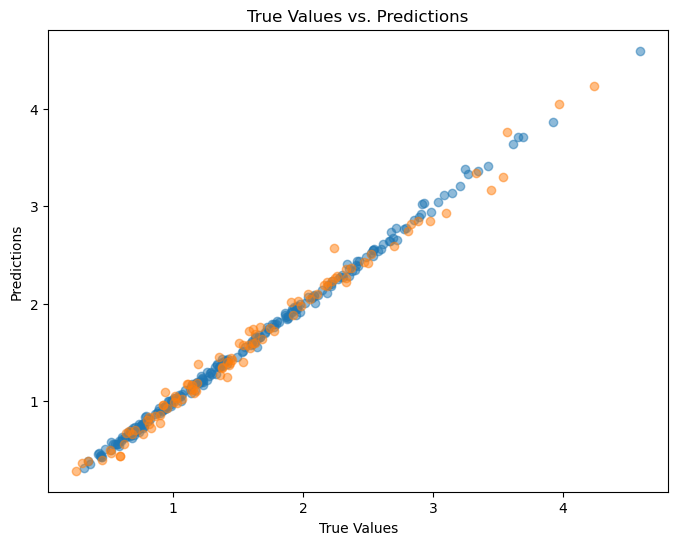

In [18]:
import matplotlib.pyplot as plt
# 对数据进行相应的可视化操作
plt.figure(figsize=(8, 6))  # 设置图形大小
# 绘制散点图

plt.scatter(y_train, y_train_pred, alpha=0.5)  # 绘制散点图，alpha参数控制点的透明度
plt.scatter(y_test, y_test_pred, alpha=0.5)  # 绘制散点图，alpha参数控制点的透明度
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True Values vs. Predictions')

# 绘制一条对角线，表示理想情况下预测值等于真实值
# plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')

# 显示图形
plt.show()

In [14]:
#导入数据
data = pd.read_excel(r"F:\OneDrive - csu.edu.cn\1-科技论文\3-机器学习预测算法\4-温度数据分析\温度数据总表.xlsx")
# 分离特征值和结果值
data_x = np.array(data.iloc[:,0:6])
data_y =np.array(data.iloc[:,6:7]) 
X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, test_size=0.3, random_state=42)
X_train_origin_data = pd.DataFrame(X_train)
X_test_origin_data = pd.DataFrame(X_test)
y_train_origin_data = pd.DataFrame(y_train)
y_test_origin_data = pd.DataFrame(y_test)
train_origin_data = pd.concat([X_train_origin_data,y_train_origin_data],axis=1,ignore_index=True)
test_origin_data = pd.concat([X_test_origin_data,y_test_origin_data],axis=1,ignore_index=True)
train_origin_data = train_origin_data.to_csv(r'F:\OneDrive - csu.edu.cn\1-科技论文\3-机器学习预测算法\4-温度数据分析\train_temp_data.csv')
test_origin_data = test_origin_data.to_csv(r'F:\OneDrive - csu.edu.cn\1-科技论文\3-机器学习预测算法\4-温度数据分析\test_temp_data.csv')